In [2]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, get_file_number, local_earthquake_quicklook
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame

In [4]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=1000, 
                latitude=47.60, 
                longitude=-122.33)
event_df = get_summary_data_frame(events)
this_id = 'uw61855012'
this_event = event_df[event_df.id==this_id]
t0 = this_event['time'].iloc[0]

cable = 'whidbey'
record_length = 5 #minutes

if cable == 'seadasn':
    prefix = 'seadasn'
    network_name = 'SeaDAS-N'
    if t0 < datetime.datetime(2022, 6, 20, 0, 0, 0):
        datastore='/data/data0/seadasn_2022-03-17_2022-06-20/'
    else:
        datastore='/data/data7/seadasn/'
        
elif cable == 'whidbey':
    prefix = 'whidbey'
    network_name='Whidbey-DAS'
    datastore = '/data/data5/Converted/'

data,dates,attrs = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=True)
x_max=data.shape[1] * attrs['SpatialSamplingInterval']

/data/data5/Converted/whidbey_2022-07-20_04-12*.h5
/data/data5/Converted/whidbey_2022-07-20_04-13*.h5
/data/data5/Converted/whidbey_2022-07-20_04-14*.h5
/data/data5/Converted/whidbey_2022-07-20_04-15*.h5
/data/data5/Converted/whidbey_2022-07-20_04-16*.h5


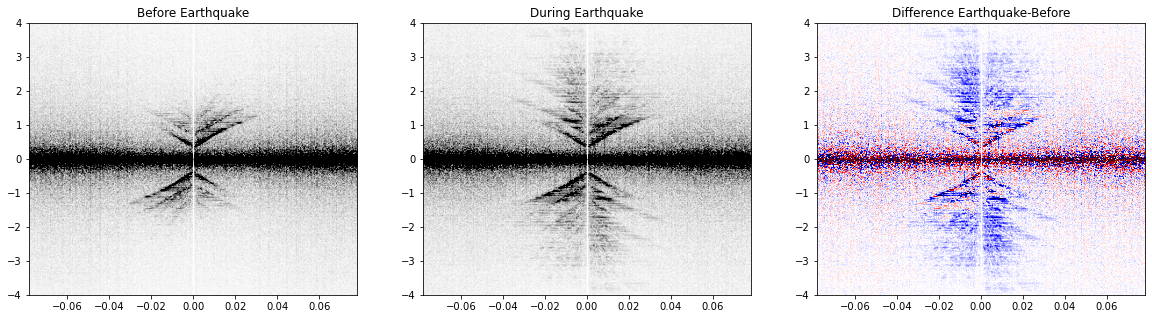

In [5]:
from scipy.signal import detrend
from scipy.fft import fftshift, fftfreq, fft2
x1 = 1225     # Entire subsea region
x2 = 1600

t1 = 0
t2 = 5000
downsamplefactor = 1
subsea_data = detrend(data[t1:t2,x1:x2])
downsampled_subsea_data = subsea_data[::downsamplefactor,:]

ft = fftshift(fft2(downsampled_subsea_data))
f = fftshift(fftfreq(downsampled_subsea_data.shape[0], d=0.01 * downsamplefactor))
k = fftshift(fftfreq(downsampled_subsea_data.shape[1], d=attrs['SpatialSamplingInterval']))

plt.subplots(1,3,figsize=(20,5))


ax1=plt.subplot(131)
plt.imshow(np.abs(ft),aspect='auto',vmin=0,vmax=10000,extent=[k[0],k[-1],f[0],f[-1]],cmap='gray_r')
plt.ylim([-4,4])
ax1.title.set_text('Before Earthquake')

t1 = 6000
t2 = 11000
downsamplefactor = 1
subsea_data = detrend(data[t1:t2,x1:x2])
downsampled_subsea_data = subsea_data[::downsamplefactor,:]

ft2 = fftshift(fft2(downsampled_subsea_data))
f = fftshift(fftfreq(downsampled_subsea_data.shape[0], d=0.01 * downsamplefactor))
k = fftshift(fftfreq(downsampled_subsea_data.shape[1], d=attrs['SpatialSamplingInterval']))

ax2=plt.subplot(132)
plt.imshow(np.abs(ft2),aspect='auto',vmin=0,vmax=10000,extent=[k[0],k[-1],f[0],f[-1]],cmap='gray_r')
plt.ylim([-4,4])
ax2.title.set_text('During Earthquake')

ax3=plt.subplot(133)
plt.imshow(np.abs(ft2)-np.abs(ft),aspect='auto',vmin=-10000,vmax=10000,extent=[k[0],k[-1],f[0],f[-1]],cmap='seismic_r')
plt.ylim([-4,4])
ax3.title.set_text('Difference Earthquake-Before')